# Comparison of data structures

### Set values for whether you would like to generate new results or just use the JSON that has previously been generated

In [1]:
# Set to true if you want to run the tests again. Otherwise just loads results from JSON
GENERATE_NEW_RESULTS = False

# Set to true if you want to save figures to disk. Change path as needed
SAVE_FIGURES_TO_DISK = False
FIG_SAVE_PATH = "../../thesis/figures/props/"

Load in packages and set options for prettier plots

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.9)

import concurrent.futures
import numpy as np
import json

from helper_funcs import save_fig, MORTON, ROW_ARR, BLOCK_ARR
from propagation_level_dist import gen_prop_dist_res, gen_avg_prop_dist_res, plot_prop_dist

from data_structures.morton_order import MortonOrder
from data_structures.block_array import BlockArray
from data_structures.row_major_array import RowMajorArray

In [3]:
matplotlib.rcParams['figure.figsize'] = (1.1*18.0, 1.1*4.8)
font = {'size' : 16}
matplotlib.rc('font', **font)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

# Avg of avg neighbour dist
### Defining functions/variables to run tests

In [4]:
def avg_dist_to_neighbors_from_voxel(element, x, y, z):
    """
    Calculates the average distance to neighbors in linear address space
    at a specific voxel
    """
    internal_index = element.internal_index(x, y, z)
    summ, elements_counted = 0, 0
    for x_inc in range(-1, 2):
        for y_inc in range(-1, 2):
            for z_inc in range(-1, 2):
                x_here = x + x_inc
                y_here = y + y_inc
                z_here = z + z_inc
                if x_inc == 0 and y_inc == 0 and z_inc == 0 or \
                   not element.valid_index(x_here, y_here, z_here):
                    continue
                index_here = element.internal_index(x_here, y_here, z_here)
                summ += abs(internal_index - index_here)
                elements_counted += 1
    return float(summ) / elements_counted


def avg_of_avg_dist_to_neighbors(element):
    """
    Calculates the average of all average distances in linear
    address space to neighbors in a data structure
    """
    summ = 0.0
    for (x, y, z) in element.iter_keys():
        summ += avg_dist_to_neighbors_from_voxel(element, x, y, z)
    return summ / np.prod(element.shape)

In [5]:
def avg_dist_for_n_and_data(data):
    avg = avg_of_avg_dist_to_neighbors(data)
    print(f"{data.print_name} {data.shape} finished")
    return data.print_name, avg

def avg_dist_for_n(n):
    rnd_vals = np.random.rand(n, n, n)
    test_vals = [
        MortonOrder(rnd_vals),
        BlockArray(rnd_vals),
        RowMajorArray(rnd_vals)
    ]
    res = {}
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for (name, avg) in executor.map(avg_dist_for_n_and_data, test_vals):
            res[name] = avg
    return res, n

In [6]:
ns = [2**i for i in range(2, 9)]
print(ns)

[4, 8, 16, 32, 64, 128, 256]


### Generating/loading in test results

In [7]:
if GENERATE_NEW_RESULTS:
    results = {}
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for (obj, n) in executor.map(avg_dist_for_n, ns):
            results[n] = obj

    with open('results/avg-avg-neighbor-dist.json', 'w') as f:
        json.dump(results, f, indent=4)


with open('results/avg-avg-neighbor-dist.json', 'r') as f:
    results = json.load(f)

### Print results to copy-pasteable $\LaTeX$-table

In [8]:
# Print the results in such a way that they can be copy-pasted to LaTeX table
for n in results:
    vals = results[n]
    print(f"{n:>3} & {vals[MORTON]:>8.2f} & {vals[BLOCK_ARR]:>8.2f} & {vals[ROW_ARR]:>8.2f} \\\\")

  4 &     9.54 &    11.21 &    11.21 \\
  8 &    39.78 &    40.54 &    44.26 \\
 16 &   166.61 &   169.06 &   176.86 \\
 32 &   685.82 &   690.76 &   707.89 \\
 64 &  2787.28 &  2802.51 &  2833.36 \\
128 & 11243.36 & 11282.46 & 11337.83 \\
256 & 45169.30 & 45258.10 & 45360.92 \\


# Propagation distance

In the following plots, what is meant by *propagation level* is all the pixels/voxels contained within the hypercube described by propagating that level out. It can be understood using the following image:

<img src="https://i.imgur.com/5aOMMSS.png" width="400" height="auto" />

### Generate/load results for propagation distance

In [9]:
SHAPE = (128, 128, 128)
MID = SHAPE[0] // 2
START_POINTS = [(0, 0, 0), (MID, MID, MID)]
DATA_ARRS = [
    MortonOrder(shape=SHAPE),
    RowMajorArray(shape=SHAPE),
    BlockArray(shape=SHAPE)
]

In [10]:
if GENERATE_NEW_RESULTS:
    results_prop_dist = generate_prop_dist_results(DATA_ARRS, START_POINTS)
    with open(f'results/prop-dist.json', 'w') as f:
        json.dump(results_prop_dist, f, indent=4)
        
with open('results/prop-dist.json', 'r') as f:
    results_prop_dist = json.load(f)

### Plots for propagation distance

(0, 0, 0)


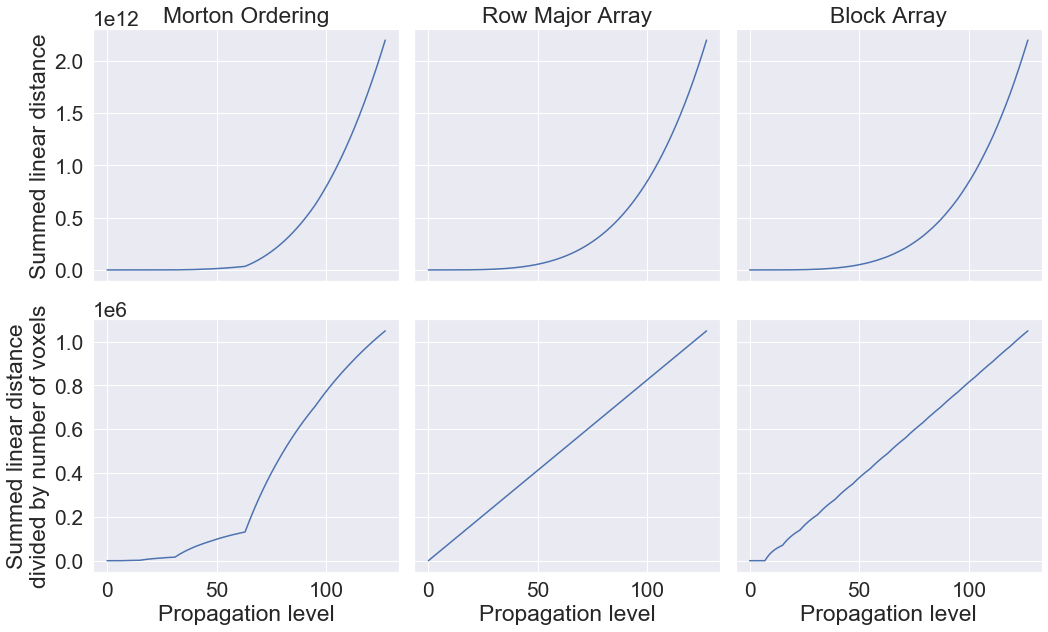

(64, 64, 64)


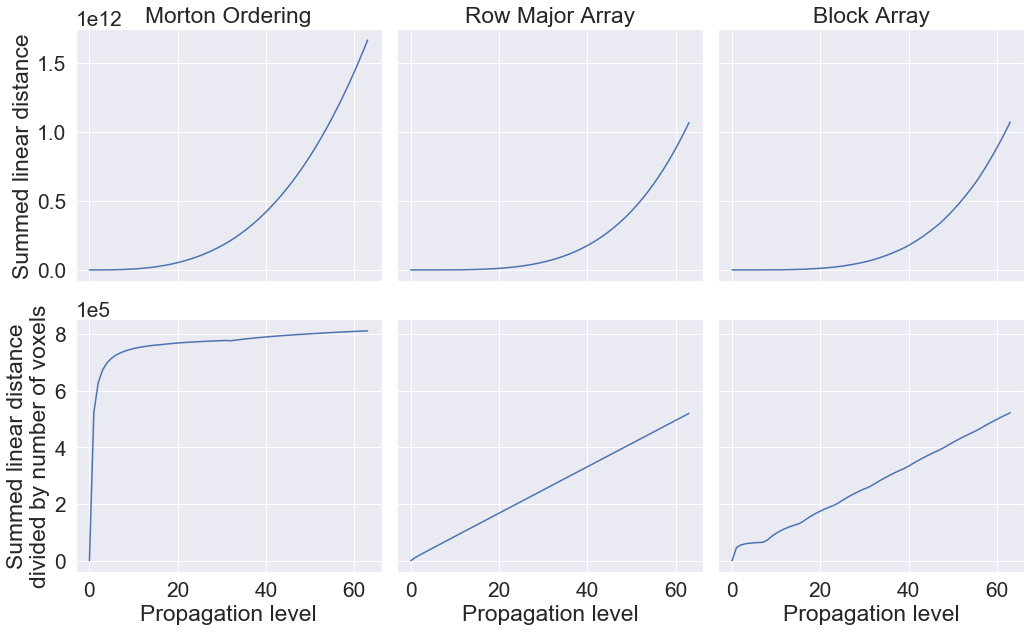

In [11]:
for start_point in START_POINTS:
    print(start_point)
    plot_prop_dist(results_prop_dist, start_point,
                   FIG_SAVE_PATH, SAVE_FIGURES_TO_DISK)

# Average propagation distance
### Generate/load average of propagation distance

In [12]:
MAX_PROP_LEVEL = 32
SHAPE = (128, 128, 128)
DATA_ARRS_AVG = [
    MortonOrder(shape=SHAPE),
    RowMajorArray(shape=SHAPE),
    BlockArray(shape=SHAPE)
]

In [13]:
if GENERATE_NEW_RESULTS:
    results_avg_prop_dist = generate_avg_prop_dist_results(DATA_ARRS_AVG, MAX_PROP_LEVEL)
    with open(f'results/prop-dist-avg.json', 'w') as f:
        json.dump(results_avg_prop_dist, f, indent=4)
        
with open('results/prop-dist-avg.json', 'r') as f:
    results_avg_prop_dist = json.load(f)

### Plot average propagation distance

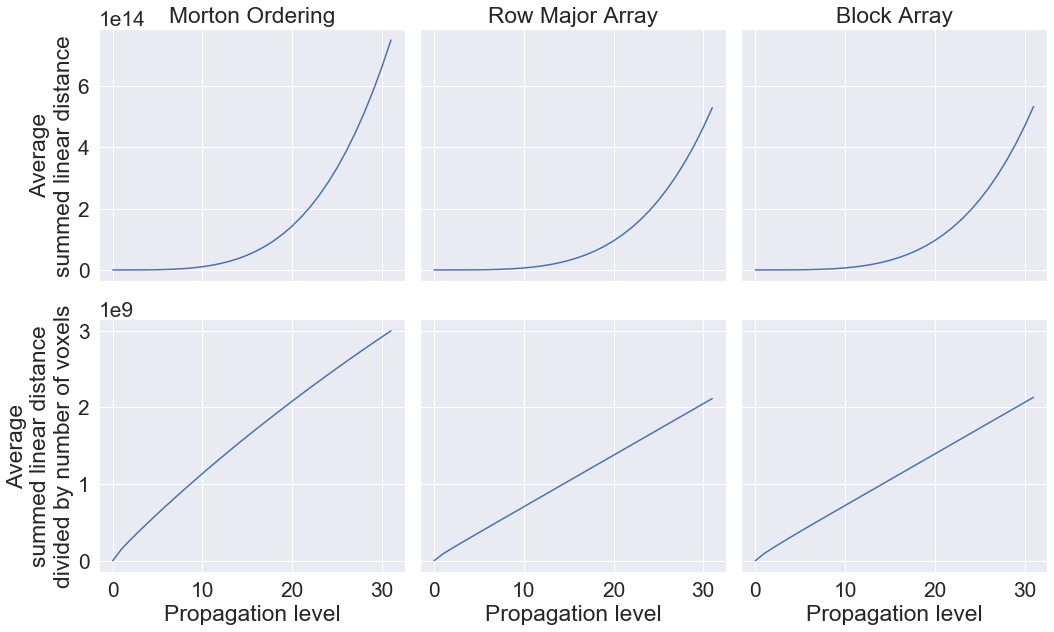

In [14]:
plot_prop_dist(results_avg_prop_dist, None, FIG_SAVE_PATH, SAVE_FIGURES_TO_DISK)